# 使用强化学习逆向设计 MMI 耦合器

本项目旨在使用 `ceviche-challenges` 库，通过强化学习算法逆向设计一个多模干涉 (MMI) 耦合器。

In [1]:
# 检查 GPU 是否可用
import torch
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")

CUDA Available: True
GPU Device: NVIDIA GeForce RTX 3060


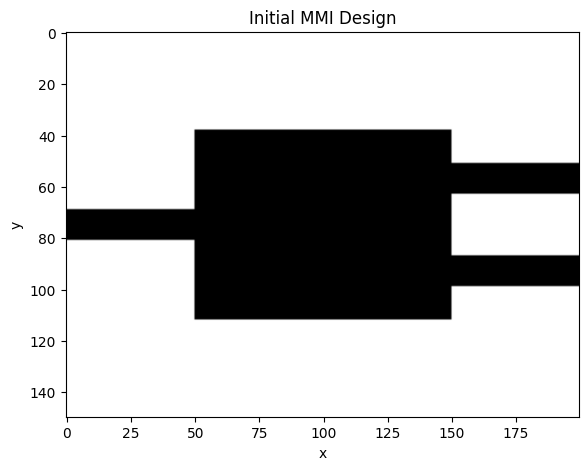

In [2]:
import numpy as np
import matplotlib.pylab as plt

import ceviche
from ceviche import fdfd_ez, jacobian
from ceviche.modes import insert_mode

# 定义仿真参数
wavelength = 1.55e-6
omega = 2 * np.pi * ceviche.constants.C_0 / wavelength
dl = 40e-9
npml = 20
nx, ny = 200, 150
epsr_background = 1.0**2 # 背景折射率 (空气)
epsr_si = 3.45**2      # 硅的折射率

# 定义 MMI 结构
epsr = np.ones((nx, ny)) * epsr_background

# 输入/输出波导宽度
wg_width_cells = int(0.5e-6 / dl)

# 输入波导
input_wg_y_start = ny // 2 - wg_width_cells // 2
input_wg_y_end = ny // 2 + wg_width_cells // 2
epsr[0:nx//4, input_wg_y_start:input_wg_y_end] = epsr_si

# MMI body (设计区域)
mmi_x_start = nx // 4
mmi_x_end = 3 * nx // 4
mmi_y_start = ny // 2 - int(3e-6 / dl) // 2
mmi_y_end = ny // 2 + int(3e-6 / dl) // 2
epsr[mmi_x_start:mmi_x_end, mmi_y_start:mmi_y_end] = epsr_si

# 输出波导 1
output_wg1_y_start = ny // 2 - int(1.5e-6 / dl) // 2 - wg_width_cells // 2
output_wg1_y_end = ny // 2 - int(1.5e-6 / dl) // 2 + wg_width_cells // 2
epsr[3*nx//4:, output_wg1_y_start:output_wg1_y_end] = epsr_si

# 输出波导 2
output_wg2_y_start = ny // 2 + int(1.5e-6 / dl) // 2 - wg_width_cells // 2
output_wg2_y_end = ny // 2 + int(1.5e-6 / dl) // 2 + wg_width_cells // 2
epsr[3*nx//4:, output_wg2_y_start:output_wg2_y_end] = epsr_si

# 创建仿真对象
F = fdfd_ez(omega, dl, epsr, npml=[npml, npml])

# 可视化初始结构
plt.figure(figsize=(10, 5))
plt.imshow(np.sqrt(epsr.T), cmap='Greys')
plt.title('Initial MMI Design')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


正在计算输入功率的参考基准...
计算完成！参考输入功率 (Power In Reference) = 5.1265e-12

对初始全硅设计进行基准测试...

初始设计真实性能评估
端口 1 真实传输率: 0.3407 (34.07%)
端口 2 真实传输率: 0.3407 (34.07%)
真实总传输率 (效率): 0.6814 (68.14%)
分光不平衡度: 0.0000

结论：初始设计的真实效率较低，为强化学习优化提供了巨大的提升空间。


/tmp/ipykernel_1353/949072913.py:64: UserWarning: Glyph 21442 (\N{CJK UNIFIED IDEOGRAPH-53C2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1353/949072913.py:64: UserWarning: Glyph 32771 (\N{CJK UNIFIED IDEOGRAPH-8003}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1353/949072913.py:64: UserWarning: Glyph 30452 (\N{CJK UNIFIED IDEOGRAPH-76F4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1353/949072913.py:64: UserWarning: Glyph 27874 (\N{CJK UNIFIED IDEOGRAPH-6CE2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1353/949072913.py:64: UserWarning: Glyph 23548 (\N{CJK UNIFIED IDEOGRAPH-5BFC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1353/949072913.py:64: UserWarning: Glyph 22330 (\N{CJK UNIFIED IDEOGRAPH-573A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1353/949072913.py:64: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missi

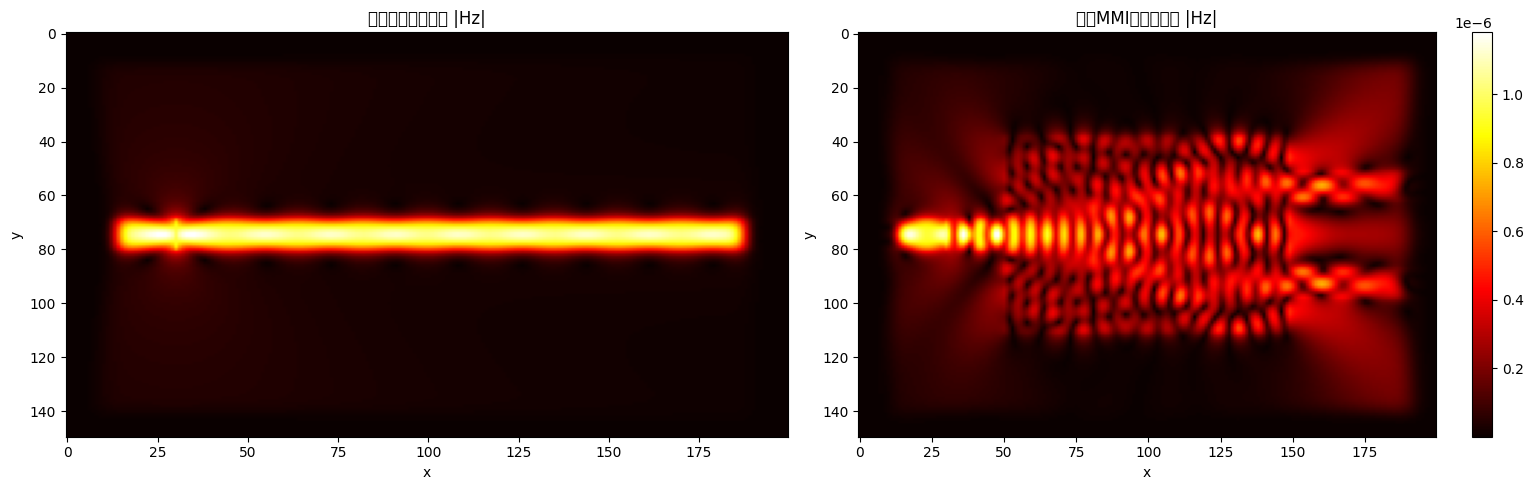

In [3]:
# =======================================================
# 步骤 1: 建立输入功率的参考基准
# =======================================================
# 为了准确计算效率(总传输率)，我们需要一个可靠的输入功率基准。
# 最佳实践是：仿真一个与 MMI 等长的、无反射的“理想”器件(即直波导)，
# 测量其输出功率。这个值将作为我们衡量所有设计的“100%输入功率”基准。

print("正在计算输入功率的参考基准...")

# 创建一个直波导结构
epsr_straight = np.ones((nx, ny), dtype=np.float32) * epsr_background
epsr_straight[:, input_wg_y_start:input_wg_y_end] = epsr_si
F_straight = fdfd_ez(omega, dl, epsr_straight, npml=[npml, npml])
source_straight = insert_mode(omega, dl, npml + 10, 
                              np.arange(input_wg_y_start, input_wg_y_end), 
                              epsr_straight, npml=npml, m=1)
_, _, Hz_ref = F_straight.solve(source_straight)
power_in_reference = np.sum(np.abs(Hz_ref[nx - npml - 10, input_wg_y_start:input_wg_y_end])**2)

print(f"计算完成！参考输入功率 (Power In Reference) = {power_in_reference:.4e}")

# =======================================================
# 步骤 2: 仿真和评估初始全硅方案
# =======================================================
print("\n对初始全硅设计进行基准测试...")

# 为初始设计创建一个独立的、干净的仿真对象，避免状态污染
# `epsr` 变量是在上一个单元格中定义的初始全硅结构
F_init_benchmark = fdfd_ez(omega, dl, epsr, npml=[npml, npml])
source_init = insert_mode(omega, dl, npml + 10, 
                          np.arange(input_wg_y_start, input_wg_y_end), 
                          epsr, npml=npml, m=1)
# 使用这个干净的仿真对象进行求解
_, _, Hz_init = F_init_benchmark.solve(source_init)

# 计算输出功率
power_out1_init = np.sum(np.abs(Hz_init[nx - npml - 10, output_wg1_y_start:output_wg1_y_end])**2)
power_out2_init = np.sum(np.abs(Hz_init[nx - npml - 10, output_wg2_y_start:output_wg2_y_end])**2)

# 使用参考基准计算真实传输率
T1_init_true = power_out1_init / power_in_reference
T2_init_true = power_out2_init / power_in_reference
total_T_init_true = T1_init_true + T2_init_true

print("\n" + "="*40)
print("初始设计真实性能评估")
print("="*40)
print(f"端口 1 真实传输率: {T1_init_true:.4f} ({T1_init_true*100:.2f}%)")
print(f"端口 2 真实传输率: {T2_init_true:.4f} ({T2_init_true*100:.2f}%)")
print(f"真实总传输率 (效率): {total_T_init_true:.4f} ({total_T_init_true*100:.2f}%)")
print(f"分光不平衡度: {np.abs(T1_init_true - T2_init_true):.4f}")
print("="*40)
print("\n结论：初始设计的真实效率较低，为强化学习优化提供了巨大的提升空间。")

# 可视化场分布
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
axes[0].imshow(np.abs(Hz_ref.T), cmap='hot', aspect='auto')
axes[0].set_title('参考直波导场分布 |Hz|')
axes[0].set_xlabel('x'); axes[0].set_ylabel('y')
im1 = axes[1].imshow(np.abs(Hz_init.T), cmap='hot', aspect='auto')
axes[1].set_title('初始MMI设计场分布 |Hz|')
axes[1].set_xlabel('x'); axes[1].set_ylabel('y')
fig.colorbar(im1, ax=axes[1])
plt.tight_layout()
plt.show()

In [4]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class MMIEnv(gym.Env):
    def __init__(self, F, epsr_background, epsr_si, mmi_x_start, mmi_x_end, mmi_y_start, mmi_y_end,
                 block_size: int = 4, max_steps_per_episode: int = 200, initial_design: np.ndarray = None,
                 power_in_reference: float = None):
        super(MMIEnv, self).__init__()
        
        self.F = F
        self.epsr_background = float(epsr_background)
        self.epsr_si = float(epsr_si)
        self.power_in_reference = power_in_reference  # 参考基准功率，用于绝对归一化
        
        self.mmi_x_start = mmi_x_start
        self.mmi_x_end = mmi_x_end
        self.mmi_y_start = mmi_y_start
        self.mmi_y_end = mmi_y_end
        
        self.design_shape = (mmi_x_end - mmi_x_start, mmi_y_end - mmi_y_start)
        
        # Block-based actions to reduce action space
        self.block_size = int(block_size)
        self.blocks_shape = (self.design_shape[0] // self.block_size, self.design_shape[1] // self.block_size)
        self.action_space = spaces.Discrete(self.blocks_shape[0] * self.blocks_shape[1])
        
        # Observation: normalized epsr values in design region (float32)
        shape = (1, self.design_shape[0], self.design_shape[1])
        self.observation_space = spaces.Box(low=0.0, high=1.0,
                                            shape=shape, dtype=np.float32)
        
        self.epsr_init = self._create_initial_epsr()
        self.custom_initial_design = initial_design

        if self.custom_initial_design is not None:
            self.state = self.custom_initial_design.copy().astype(np.float32)
        else:
            self.state = self.epsr_init[self.mmi_x_start:self.mmi_x_end, self.mmi_y_start:self.mmi_y_end].astype(np.float32)
        
        # Episode management
        self.max_steps_per_episode = int(max_steps_per_episode)
        self.step_count = 0
        self.prev_score = 0
        
        # 保存输入和输出波导的位置信息，用于固定它们
        self.wg_width_cells = int(0.5e-6 / dl)
        self.input_wg_y_start = ny // 2 - self.wg_width_cells // 2
        self.input_wg_y_end = ny // 2 + self.wg_width_cells // 2
        self.output_wg1_y_start = ny // 2 - int(1.5e-6 / dl) // 2 - self.wg_width_cells // 2
        self.output_wg1_y_end = ny // 2 - int(1.5e-6 / dl) // 2 + self.wg_width_cells // 2
        self.output_wg2_y_start = ny // 2 + int(1.5e-6 / dl) // 2 - self.wg_width_cells // 2
        self.output_wg2_y_end = ny // 2 + int(1.5e-6 / dl) // 2 + self.wg_width_cells // 2

    def _create_initial_epsr(self):
        epsr = np.ones((nx, ny), dtype=np.float32) * self.epsr_background
        wg_width_cells = int(0.5e-6 / dl)
        input_wg_y_start = ny // 2 - wg_width_cells // 2
        input_wg_y_end = ny // 2 + wg_width_cells // 2
        
        # 固定输入波导（在MMI之前）
        epsr[0:self.mmi_x_start, input_wg_y_start:input_wg_y_end] = self.epsr_si
        
        # MMI初始为硅（整个区域）
        epsr[self.mmi_x_start:self.mmi_x_end, self.mmi_y_start:self.mmi_y_end] = self.epsr_si
        
        # 固定输出波导1
        output_wg1_y_start = ny // 2 - int(1.5e-6 / dl) // 2 - wg_width_cells // 2
        output_wg1_y_end = ny // 2 - int(1.5e-6 / dl) // 2 + wg_width_cells // 2
        epsr[self.mmi_x_end:, output_wg1_y_start:output_wg1_y_end] = self.epsr_si
        
        # 固定输出波导2
        output_wg2_y_start = ny // 2 + int(1.5e-6 / dl) // 2 - wg_width_cells // 2
        output_wg2_y_end = ny // 2 + int(1.5e-6 / dl) // 2 + wg_width_cells // 2
        epsr[self.mmi_x_end:, output_wg2_y_start:output_wg2_y_end] = self.epsr_si
        
        return epsr

    def step(self, action):
        # Convert action index to block coordinates
        bx, by = np.unravel_index(action, self.blocks_shape)
        xs = slice(bx * self.block_size, (bx + 1) * self.block_size)
        ys = slice(by * self.block_size, (by + 1) * self.block_size)
        
        # Flip the entire block between background and silicon
        block = self.state[xs, ys]
        mask_bg = (block == self.epsr_background)
        self.state[xs, ys] = np.where(mask_bg, self.epsr_si, self.epsr_background)
        
        # Build full epsr
        epsr_full = self.epsr_init.copy()
        epsr_full[self.mmi_x_start:self.mmi_x_end, self.mmi_y_start:self.mmi_y_end] = self.state
        
        # Update FDFD object
        self.F.eps_r = epsr_full
        
        # Run simulation
        mode_y_range = np.arange(self.input_wg_y_start, self.input_wg_y_end)
        source = insert_mode(omega, dl, npml + 10, mode_y_range, epsr_full, npml=npml, m=1)
        Ex, Ey, Hz = self.F.solve(source)
        
        # Compute performance
        power_out1 = np.sum(np.abs(Hz[nx - npml - 10, self.output_wg1_y_start:self.output_wg1_y_end])**2)
        power_out2 = np.sum(np.abs(Hz[nx - npml - 10, self.output_wg2_y_start:self.output_wg2_y_end])**2)
        
        # 使用参考基准进行归一化（如果提供）
        if self.power_in_reference is not None:
            T1 = power_out1 / self.power_in_reference  # 真实传输率
            T2 = power_out2 / self.power_in_reference  # 真实传输率
        else:
            # 回退到相对归一化（旧版本兼容）
            total_power = power_out1 + power_out2 + 1e-10
            T1 = power_out1 / total_power
            T2 = power_out2 / total_power
        
        # 多维奖励函数设计：
        efficiency = T1 + T2
        balance_penalty = np.abs(T1 - T2)
        min_port_efficiency = min(T1, T2)
        ideal_splitting = 1.0 - 2 * np.abs(T1 - 0.5)  # T1=0.5时为1.0，越偏离越小
        
        # 综合得分（可调整权重）
        current_score = (2.0 * efficiency + 
                        1.0 * ideal_splitting + 
                        1.0 * min_port_efficiency - 
                        3.0 * balance_penalty)
        
        # 增量奖励：只奖励改进
        reward = current_score - self.prev_score
        self.prev_score = current_score
        
        # Episode termination
        self.step_count += 1
        terminated = (self.step_count >= self.max_steps_per_episode)
        truncated = False
        
        state_normalized = self.state.copy() / self.epsr_si
        return state_normalized.reshape(1, *self.design_shape), reward, terminated, truncated, {}

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        if self.custom_initial_design is not None:
            self.state = self.custom_initial_design.copy().astype(np.float32)
        else:
            self.state = self.epsr_init[self.mmi_x_start:self.mmi_x_end, self.mmi_y_start:self.mmi_y_end].astype(np.float32)

        self.step_count = 0

        # 计算初始结构的当前得分，用于增量奖励起点
        epsr_full = self.epsr_init.copy()
        epsr_full[self.mmi_x_start:self.mmi_x_end, self.mmi_y_start:self.mmi_y_end] = self.state
        mode_y_range = np.arange(self.input_wg_y_start, self.input_wg_y_end)
        source = insert_mode(omega, dl, npml + 10, mode_y_range, epsr_full, npml=npml, m=1)
        _, _, Hz = self.F.solve(source)
        power_out1 = np.sum(np.abs(Hz[nx - npml - 10, self.output_wg1_y_start:self.output_wg1_y_end])**2)
        power_out2 = np.sum(np.abs(Hz[nx - npml - 10, self.output_wg2_y_start:self.output_wg2_y_end])**2)
        if self.power_in_reference is not None:
            T1 = power_out1 / self.power_in_reference
            T2 = power_out2 / self.power_in_reference
        else:
            total_power = power_out1 + power_out2 + 1e-10
            T1 = power_out1 / total_power
            T2 = power_out2 / total_power
        efficiency = T1 + T2
        balance_penalty = np.abs(T1 - T2)
        min_port_efficiency = min(T1, T2)
        ideal_splitting = 1.0 - 2 * np.abs(T1 - 0.5)
        self.prev_score = (2.0 * efficiency + 
                          1.0 * ideal_splitting + 
                          1.0 * min_port_efficiency - 
                          3.0 * balance_penalty)

        state_normalized = self.state.copy() / self.epsr_si
        return state_normalized.reshape(1, *self.design_shape), {}

    def render(self, mode='human'):
        plt.figure(figsize=(10, 5))
        plt.imshow(np.sqrt(self.state.T), cmap='Greys')
        plt.title('Current MMI Design')
        plt.show()

In [5]:
# ==================== 验证：初始设计在新奖励函数下的得分 ====================
print("\n" + "="*60)
print("初始设计的奖励函数评分")
print("="*60)

# 使用初始基准测试的结果
T1_init = T1_init_true
T2_init = T2_init_true

# 计算多维指标
efficiency_init = T1_init + T2_init
balance_penalty_init = np.abs(T1_init - T2_init)
min_port_init = min(T1_init, T2_init)
ideal_splitting_init = 1.0 - 2 * np.abs(T1_init - 0.5)

# 综合得分
score_init = (2.0 * efficiency_init + 
              1.0 * ideal_splitting_init + 
              1.0 * min_port_init - 
              3.0 * balance_penalty_init)

print(f"\n多维指标分解：")
print(f"  总传输效率 (T1+T2):        {efficiency_init:.4f}  (权重: 2.0)")
print(f"  理想分光比 1-2|T1-0.5|:   {ideal_splitting_init:.4f}  (权重: 1.0)")
print(f"  最小端口效率 min(T1,T2):  {min_port_init:.4f}  (权重: 1.0)")
print(f"  平衡性惩罚 -|T1-T2|:      {-balance_penalty_init:.4f}  (权重: 3.0)")
print(f"\n综合得分: {score_init:.4f}")
print(f"\n理论最大得分 (T1=T2=0.5): {2.0*1.0 + 1.0*1.0 + 1.0*0.5 - 3.0*0.0:.4f}")
print(f"得分占比: {score_init / 3.5 * 100:.2f}%")
print("="*60)



初始设计的奖励函数评分

多维指标分解：
  总传输效率 (T1+T2):        0.6814  (权重: 2.0)
  理想分光比 1-2|T1-0.5|:   0.6814  (权重: 1.0)
  最小端口效率 min(T1,T2):  0.3407  (权重: 1.0)
  平衡性惩罚 -|T1-T2|:      -0.0000  (权重: 3.0)

综合得分: 2.3847

理论最大得分 (T1=T2=0.5): 3.5000
得分占比: 68.14%


In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
import torch
import torch.nn as nn
from IPython.display import clear_output
import numpy as np
import matplotlib.pylab as plt

# ==================================
# 1. 设置训练参数
# ==================================
TOTAL_TIMESTEPS = 10000
COARSE_STEPS = TOTAL_TIMESTEPS // 4
FINE_STEPS = TOTAL_TIMESTEPS - COARSE_STEPS

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
print(f"Total timesteps: {TOTAL_TIMESTEPS}")
print(f"Phase 1 (Coarse, block_size=8): {COARSE_STEPS} steps")
print(f"Phase 2 (Fine, block_size=4): {FINE_STEPS} steps")

# ==================================
# 2. 定义回调函数 (通用)
# ==================================
class AdvancedTrainingCallback(BaseCallback):
    def __init__(self, check_freq=50, save_design_freq=200, phase_name="Training", vmin=1.0, vmax=3.5, verbose=1):
        super(AdvancedTrainingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_design_freq = save_design_freq
        self.phase_name = phase_name
        self.vmin = vmin
        self.vmax = vmax
        self.rewards = []
        self.timesteps = []
        self.episode_rewards = []
        
    def _on_step(self):
        if hasattr(self.model.env, 'buf_rews'):
            self.episode_rewards.append(float(np.mean(self.model.env.buf_rews)))
        
        if self.n_calls % self.check_freq == 0 and len(self.episode_rewards) > 0:
            mean_reward = float(np.mean(self.episode_rewards[-self.check_freq:]))
            self.rewards.append(mean_reward)
            self.timesteps.append(self.num_timesteps)
            print(f"[{self.phase_name}] Step {self.num_timesteps}: Mean Reward = {mean_reward:.4f}")
        
        if self.n_calls > 0 and self.n_calls % self.save_design_freq == 0:
            clear_output(wait=True)
            current_design = self.model.env.envs[0].unwrapped.state.copy()
            fig, axes = plt.subplots(1, 2, figsize=(15, 4))
            axes[0].plot(self.timesteps, self.rewards, 'b.-', label='Mean Reward')
            axes[0].set_title(f'{self.phase_name} Progress')
            axes[0].set_xlabel('Timesteps'); axes[0].set_ylabel('Mean Reward'); axes[0].legend(); axes[0].grid(True, alpha=0.3)
            im = axes[1].imshow(np.sqrt(current_design.T), cmap='Greys', aspect='auto', vmin=self.vmin, vmax=self.vmax)
            axes[1].set_title(f'Design at Step {self.num_timesteps}')
            #fig.colorbar(im, ax=axes[1]) # Optional: add a colorbar to check the values
            plt.tight_layout(); plt.show()
        return True

# ==================================
# 3. 阶段一：粗粒度训练
# ==================================
print("\n" + "="*60)
print(f"PHASE 1: Coarse Training (block_size=8) for {COARSE_STEPS} steps")
print("="*60)
print(f"✓ 使用参考基准功率: {power_in_reference:.4e}\n")

def make_coarse_env():
    return MMIEnv(F, epsr_background, epsr_si, mmi_x_start, mmi_x_end, mmi_y_start, mmi_y_end,
                  block_size=8, max_steps_per_episode=200, 
                  power_in_reference=power_in_reference)

vec_env_coarse = DummyVecEnv([make_coarse_env])
model_coarse = PPO('CnnPolicy', vec_env_coarse, verbose=0,
                   learning_rate=3e-4, n_steps=256, batch_size=64, gamma=0.99,
                   clip_range=0.2, gae_lambda=0.95, device=device, ent_coef=0.05,
                   policy_kwargs=dict(normalize_images=False))

callback_coarse = AdvancedTrainingCallback(check_freq=50, save_design_freq=200, phase_name="Coarse", 
                                           vmin=np.sqrt(epsr_background), vmax=np.sqrt(epsr_si))
model_coarse.learn(total_timesteps=COARSE_STEPS, callback=callback_coarse)
coarse_design = vec_env_coarse.envs[0].unwrapped.state.copy()

print("\nCoarse training complete. Design from this phase:")
plt.figure(figsize=(6, 4)); plt.imshow(np.sqrt(coarse_design.T), cmap='Greys', vmin=np.sqrt(epsr_background), vmax=np.sqrt(epsr_si));
plt.title('Design after Coarse Training'); plt.show()

del model_coarse, vec_env_coarse

# ==================================
# 4. 阶段二：细粒度训练
# ==================================
print("\n" + "="*60)
print(f"✓ 使用参考基准功率: {power_in_reference:.4e}\n")

def make_fine_env():
    return MMIEnv(F, epsr_background, epsr_si, mmi_x_start, mmi_x_end, mmi_y_start, mmi_y_end,
                  block_size=4, max_steps_per_episode=200, initial_design=coarse_design,
                  power_in_reference=power_in_reference)

vec_env_fine = DummyVecEnv([make_fine_env])
model_fine = PPO('CnnPolicy', vec_env_fine, verbose=0,
                 learning_rate=1e-4, n_steps=512, batch_size=64, gamma=0.99,
                 clip_range=0.1, gae_lambda=0.95, device=device, ent_coef=0.01, # 降低熵系数，注重利用
                 policy_kwargs=dict(normalize_images=False))

callback_fine = AdvancedTrainingCallback(check_freq=50, save_design_freq=200, phase_name="Fine-Tuning",
                                         vmin=np.sqrt(epsr_background), vmax=np.sqrt(epsr_si))
model_fine.learn(total_timesteps=FINE_STEPS, callback=callback_fine)

# ==================================
# 5. 最终结果与评估
# ==================================
# 合并训练历史用于最终绘图
total_timesteps = callback_coarse.timesteps + [t + COARSE_STEPS for t in callback_fine.timesteps]
total_rewards = callback_coarse.rewards + callback_fine.rewards

print("\n" + "=" * 60); print("Total Training Process Finished!"); print("=" * 60)
if len(total_rewards) > 0:
    plt.figure(figsize=(10, 5))
    plt.plot(total_timesteps, total_rewards, marker='.', linestyle='-', label='Mean Reward')
    plt.axvline(x=COARSE_STEPS, color='r', linestyle='--', label='Start Fine-Tuning')
    plt.xlabel('Total Timesteps'); plt.ylabel('Mean Reward'); plt.title('Full Training Progress');
    plt.legend(); plt.grid(True, alpha=0.3); plt.show()
else:
    print("Warning: No training data was recorded.")

# 获取最终优化设计并评估
env_unwrapped = vec_env_fine.envs[0].unwrapped
optimized_design = env_unwrapped.state.copy()

print("\nFinal optimized design after fine-tuning:")
plt.figure(figsize=(10, 5))
plt.imshow(np.sqrt(optimized_design.T), cmap='Greys', vmin=np.sqrt(epsr_background), vmax=np.sqrt(epsr_si))
plt.title('Final Optimized MMI Design')
plt.show()

# 使用最终设计进行评估
epsr_final = env_unwrapped.epsr_init.copy()
epsr_final[mmi_x_start:mmi_x_end, mmi_y_start:mmi_y_end] = optimized_design

mode_y_range = np.arange(ny//2 - wg_width_cells//2, ny//2 + wg_width_cells//2)
source = insert_mode(omega, dl, npml + 10, mode_y_range, epsr_final, npml=npml, m=1)
F.eps_r = epsr_final # 确保仿真器使用最新的epsr
Ex, Ey, Hz = F.solve(source)

power_out1 = np.sum(np.abs(Hz[nx - npml - 10, output_wg1_y_start:output_wg1_y_end])**2)
power_out2 = np.sum(np.abs(Hz[nx - npml - 10, output_wg2_y_start:output_wg2_y_end])**2)

if power_in_reference is not None:
    T1_final = power_out1 / power_in_reference
    T2_final = power_out2 / power_in_reference
else:
    total_power = power_out1 + power_out2 + 1e-10
    T1_final = power_out1 / total_power
    T2_final = power_out2 / total_power

print(f"Final Transmission to Port 1: {T1_final:.4f}")
print(f"Final Transmission to Port 2: {T2_final:.4f}")
print(f"Total Transmission: {T1_final + T2_final:.4f}")
print(f"Splitting Imbalance: {np.abs(T1_final - T2_final):.4f}")

Using device: cuda
Total timesteps: 10000
Phase 1 (Coarse, block_size=8): 2500 steps
Phase 2 (Fine, block_size=4): 7500 steps

PHASE 1: Coarse Training (block_size=8) for 2500 steps
✓ 使用参考基准功率: 5.1265e-12




最终设计评估


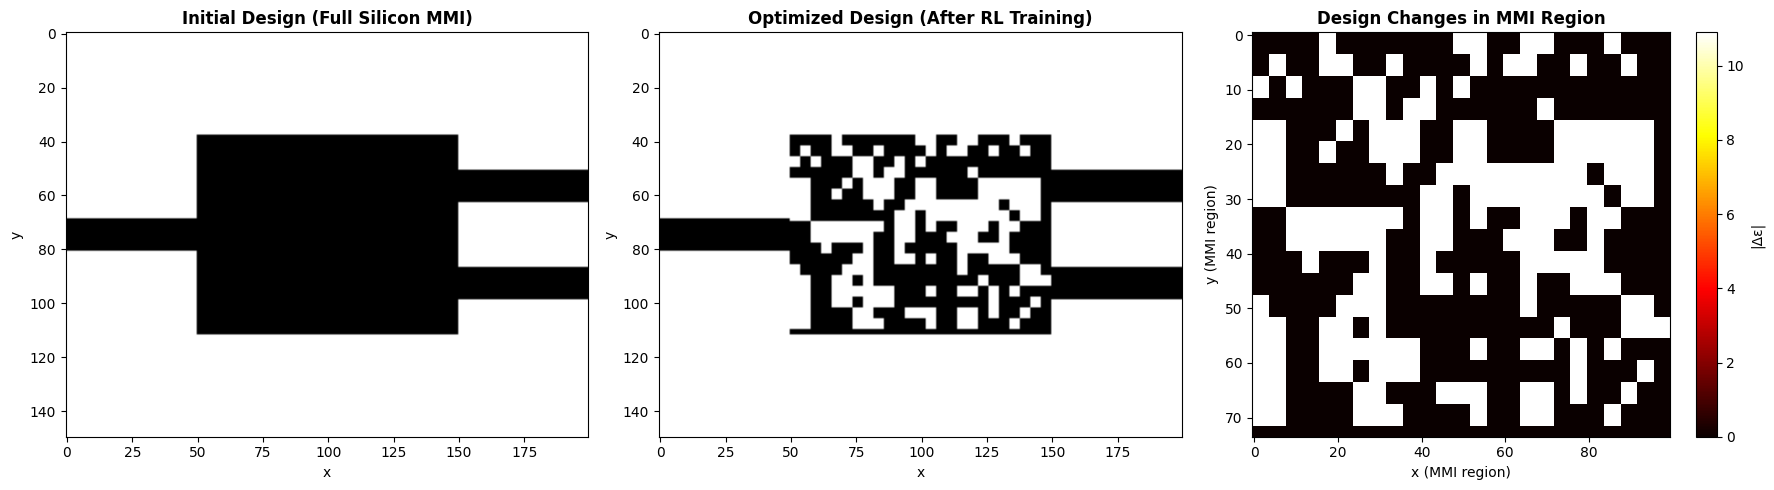


设计区域尺寸: (100, 74)
修改的像素数: 2960
修改比例: 40.00%
硅材料占比: 60.00%
空气占比: 40.00%


In [10]:
# ==================== 最终设计评估与对比 ====================

print("\n" + "=" * 60)
print("最终设计评估")
print("=" * 60)

# ✅ 正确方法：从训练后的环境中直接获取优化设计
env_unwrapped = vec_env_fine.envs[0].unwrapped
optimized_design = env_unwrapped.state.copy()  # 训练后的设计

# 创建初始设计用于对比（全硅MMI区域）
initial_design = np.ones((mmi_x_end - mmi_x_start, mmi_y_end - mmi_y_start), dtype=np.float32) * epsr_si

# 设计对比可视化
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 初始设计（完整结构）
initial_epsr_full = np.ones((nx, ny), dtype=np.float32) * epsr_background
initial_epsr_full[0:mmi_x_start, input_wg_y_start:input_wg_y_end] = epsr_si
initial_epsr_full[mmi_x_start:mmi_x_end, mmi_y_start:mmi_y_end] = epsr_si
initial_epsr_full[mmi_x_end:, output_wg1_y_start:output_wg1_y_end] = epsr_si
initial_epsr_full[mmi_x_end:, output_wg2_y_start:output_wg2_y_end] = epsr_si

axes[0].imshow(np.sqrt(initial_epsr_full.T), cmap='Greys', aspect='auto')
axes[0].set_title('Initial Design (Full Silicon MMI)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')

# 优化后的设计（完整结构）
epsr_final = env_unwrapped.epsr_init.copy()
epsr_final[mmi_x_start:mmi_x_end, mmi_y_start:mmi_y_end] = optimized_design

axes[1].imshow(np.sqrt(epsr_final.T), cmap='Greys', aspect='auto')
axes[1].set_title('Optimized Design (After RL Training)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')

# 设计区域的变化（只显示MMI区域）
difference = np.abs(optimized_design - initial_design)
im = axes[2].imshow(difference.T, cmap='hot', aspect='auto')
axes[2].set_title('Design Changes in MMI Region', fontsize=12, fontweight='bold')
axes[2].set_xlabel('x (MMI region)')
axes[2].set_ylabel('y (MMI region)')
plt.colorbar(im, ax=axes[2], label='|Δε|')

plt.tight_layout()
plt.show()

print(f"\n设计区域尺寸: {optimized_design.shape}")
print(f"修改的像素数: {np.sum(difference > 0.1)}")  # 使用阈值避免浮点误差
print(f"修改比例: {np.sum(difference > 0.1) / difference.size * 100:.2f}%")
print(f"硅材料占比: {np.sum(optimized_design >= epsr_si * 0.9) / optimized_design.size * 100:.2f}%")
print(f"空气占比: {np.sum(optimized_design <= epsr_background * 1.1) / optimized_design.size * 100:.2f}%")


电磁场仿真与性能对比


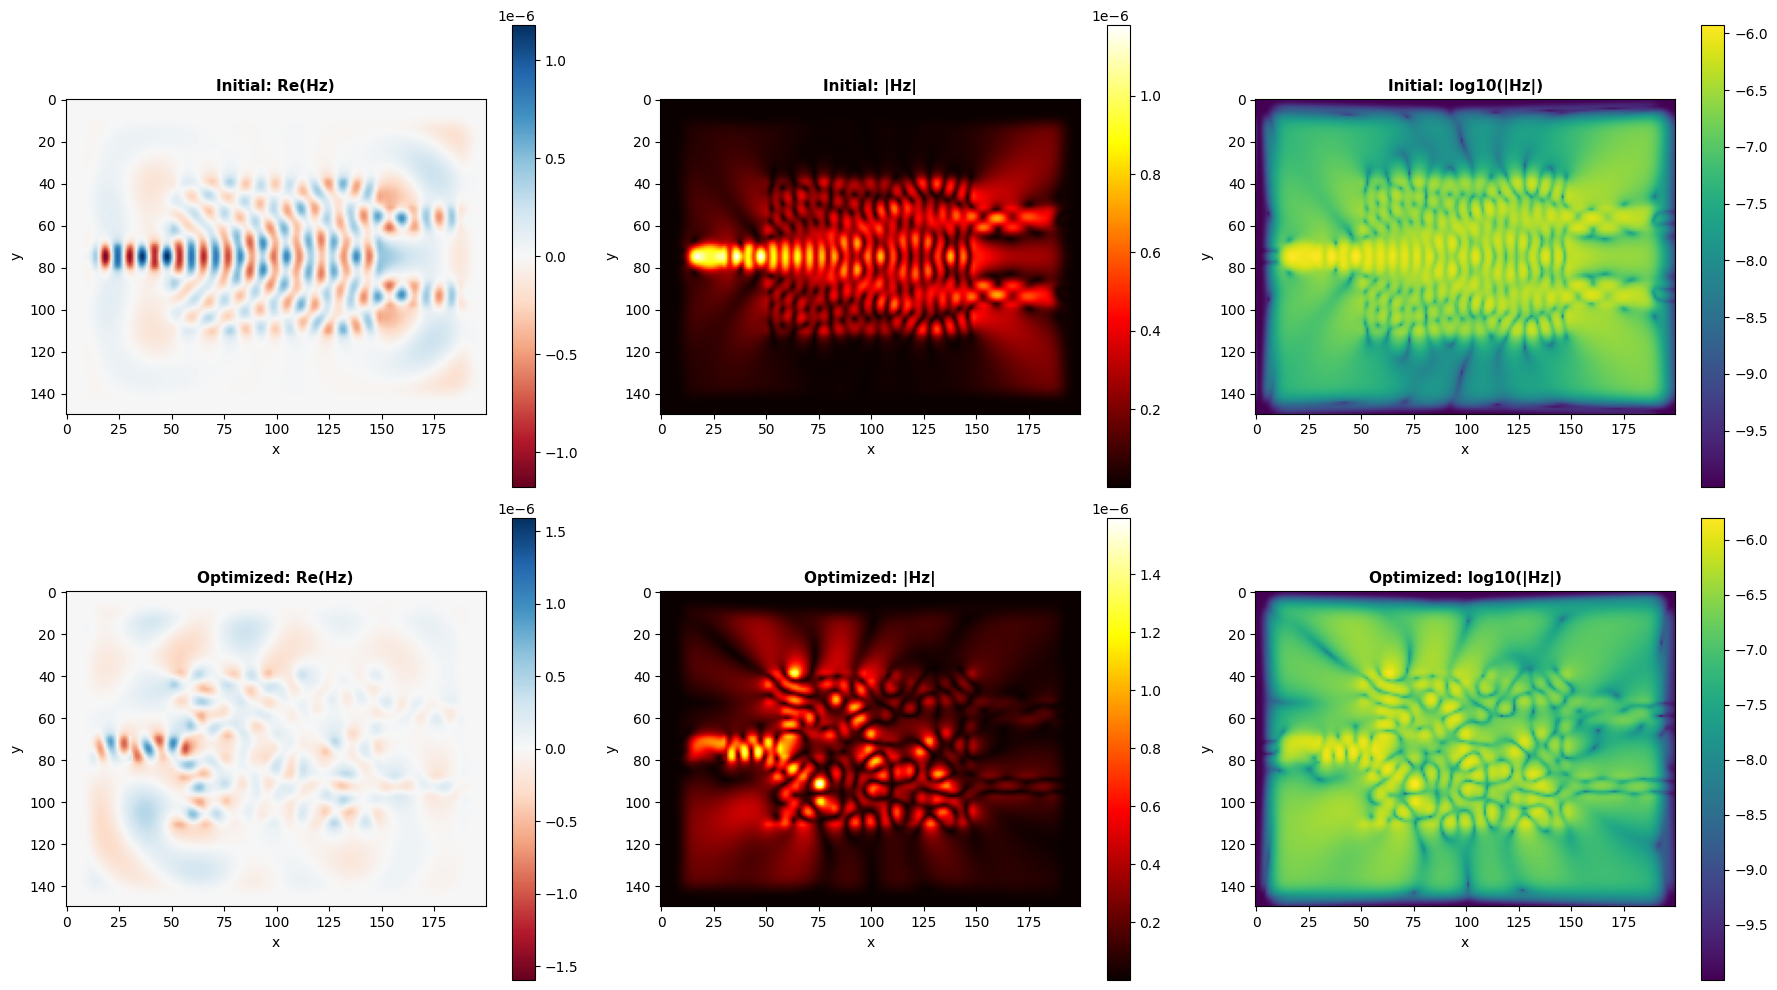


性能对比结果 (基于真实效率归一化)

指标                        初始设计            优化设计            改进             
----------------------------------------------------------------------
Port 1 传输率                0.3407          0.0299          -0.3107        
Port 2 传输率                0.3407          0.0571          -0.2836        
总传输率 (效率)                 0.6814          0.0871          -0.5943        
分光不平衡度                    0.0000          0.0272          +0.0272        
分光比 (Port1/Port2)         1.0000          0.5243          —              
----------------------------------------------------------------------


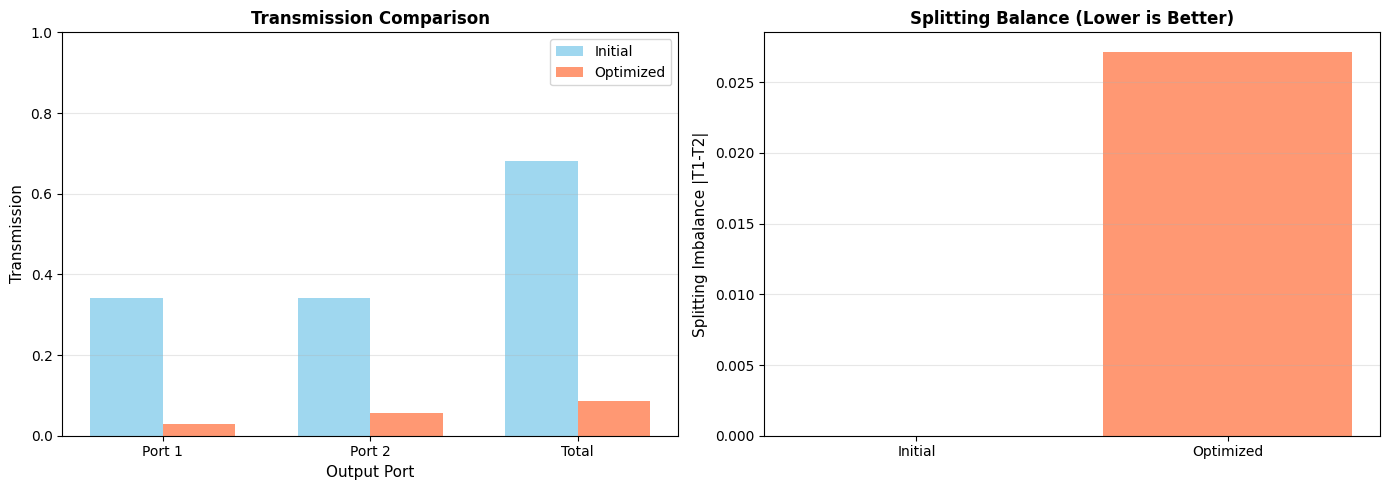


✓ 完整训练与评估流程完成！


In [11]:
# ==================== 电磁场仿真与性能评估 ====================

print("\n" + "=" * 60)
print("电磁场仿真与性能对比")
print("=" * 60)

mode_y_range = np.arange(ny//2 - wg_width_cells//2, ny//2 + wg_width_cells//2)

# ==================================
# 1. 独立仿真优化后的设计
# ==================================
# 为优化设计创建一个独立的、干净的仿真对象
F_opt = fdfd_ez(omega, dl, epsr_final, npml=[npml, npml])
source_opt = insert_mode(omega, dl, npml + 10, mode_y_range, epsr_final, npml=npml, m=1)
Ex_opt, Ey_opt, Hz_opt = F_opt.solve(source_opt)

# ==================================
# 2. 独立仿真初始设计
# ==================================
# 重新构建初始的全硅结构
initial_epsr_full = np.ones((nx, ny), dtype=np.float32) * epsr_background
initial_epsr_full[0:mmi_x_start, input_wg_y_start:input_wg_y_end] = epsr_si
initial_epsr_full[mmi_x_start:mmi_x_end, mmi_y_start:mmi_y_end] = epsr_si
initial_epsr_full[mmi_x_end:, output_wg1_y_start:output_wg1_y_end] = epsr_si
initial_epsr_full[mmi_x_end:, output_wg2_y_start:output_wg2_y_end] = epsr_si
# 为初始设计创建一个独立的、干净的仿真对象
F_init = fdfd_ez(omega, dl, initial_epsr_full, npml=[npml, npml])
source_init = insert_mode(omega, dl, npml + 10, mode_y_range, initial_epsr_full, npml=npml, m=1)
Ex_init, Ey_init, Hz_init = F_init.solve(source_init)


# 场分布对比可视化
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 第一行：初始设计的场分布
im1 = axes[0, 0].imshow(np.real(Hz_init).T, cmap='RdBu', 
                         vmin=-np.max(np.abs(Hz_init)), vmax=np.max(np.abs(Hz_init)))
axes[0, 0].set_title('Initial: Re(Hz)', fontsize=11, fontweight='bold')
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('y')
plt.colorbar(im1, ax=axes[0, 0])

im2 = axes[0, 1].imshow(np.abs(Hz_init).T, cmap='hot')
axes[0, 1].set_title('Initial: |Hz|', fontsize=11, fontweight='bold')
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('y')
plt.colorbar(im2, ax=axes[0, 1])

im3 = axes[0, 2].imshow(np.log10(np.abs(Hz_init).T + 1e-10), cmap='viridis')
axes[0, 2].set_title('Initial: log10(|Hz|)', fontsize=11, fontweight='bold')
axes[0, 2].set_xlabel('x')
axes[0, 2].set_ylabel('y')
plt.colorbar(im3, ax=axes[0, 2])

# 第二行：优化设计的场分布
im4 = axes[1, 0].imshow(np.real(Hz_opt).T, cmap='RdBu',
                         vmin=-np.max(np.abs(Hz_opt)), vmax=np.max(np.abs(Hz_opt)))
axes[1, 0].set_title('Optimized: Re(Hz)', fontsize=11, fontweight='bold')
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('y')
plt.colorbar(im4, ax=axes[1, 0])

im5 = axes[1, 1].imshow(np.abs(Hz_opt).T, cmap='hot')
axes[1, 1].set_title('Optimized: |Hz|', fontsize=11, fontweight='bold')
axes[1, 1].set_xlabel('x')
axes[1, 1].set_ylabel('y')
plt.colorbar(im5, ax=axes[1, 1])

im6 = axes[1, 2].imshow(np.log10(np.abs(Hz_opt).T + 1e-10), cmap='viridis')
axes[1, 2].set_title('Optimized: log10(|Hz|)', fontsize=11, fontweight='bold')
axes[1, 2].set_xlabel('x')
axes[1, 2].set_ylabel('y')
plt.colorbar(im6, ax=axes[1, 2])

plt.tight_layout()
plt.show()

# =============================================
# 修正：使用参考基准计算真实的性能指标
# =============================================

# 初始设计
power_out1_init = np.sum(np.abs(Hz_init[nx - npml - 10, output_wg1_y_start:output_wg1_y_end])**2)
power_out2_init = np.sum(np.abs(Hz_init[nx - npml - 10, output_wg2_y_start:output_wg2_y_end])**2)
# 使用从直波导仿真中获得的`power_in_reference`进行归一化
T1_init = power_out1_init / power_in_reference
T2_init = power_out2_init / power_in_reference

# 优化设计
power_out1_opt = np.sum(np.abs(Hz_opt[nx - npml - 10, output_wg1_y_start:output_wg1_y_end])**2)
power_out2_opt = np.sum(np.abs(Hz_opt[nx - npml - 10, output_wg2_y_start:output_wg2_y_end])**2)
# 同样使用`power_in_reference`进行归一化
T1_opt = power_out1_opt / power_in_reference
T2_opt = power_out2_opt / power_in_reference

# 性能对比表格
print("\n" + "=" * 60)
print("性能对比结果 (基于真实效率归一化)")
print("=" * 60)
print(f"\n{'指标':<25} {'初始设计':<15} {'优化设计':<15} {'改进':<15}")
print("-" * 70)
print(f"{'Port 1 传输率':<25} {T1_init:<15.4f} {T1_opt:<15.4f} {(T1_opt-T1_init):<+15.4f}")
print(f"{'Port 2 传输率':<25} {T2_init:<15.4f} {T2_opt:<15.4f} {(T2_opt-T2_init):<+15.4f}")
print(f"{'总传输率 (效率)':<25} {T1_init+T2_init:<15.4f} {T1_opt+T2_opt:<15.4f} {(T1_opt+T2_opt-T1_init-T2_init):<+15.4f}")
print(f"{'分光不平衡度':<25} {np.abs(T1_init-T2_init):<15.4f} {np.abs(T1_opt-T2_opt):<15.4f} {(np.abs(T1_opt-T2_opt)-np.abs(T1_init-T2_init)):<+15.4f}")
# 分光比在输出功率低时可能无意义或导致除零错误
with np.errstate(divide='ignore', invalid='ignore'):
    ratio_init = T1_init / T2_init if T2_init > 1e-9 else np.inf
    ratio_opt = T1_opt / T2_opt if T2_opt > 1e-9 else np.inf
    print(f"{'分光比 (Port1/Port2)':<25} {ratio_init:<15.4f} {ratio_opt:<15.4f} {'—':<15}")
print("-" * 70)

# 性能提升可视化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 传输率对比
categories = ['Port 1', 'Port 2', 'Total']
initial_vals = [T1_init, T2_init, T1_init+T2_init]
optimized_vals = [T1_opt, T2_opt, T1_opt+T2_opt]

x = np.arange(len(categories))
width = 0.35

axes[0].bar(x - width/2, initial_vals, width, label='Initial', alpha=0.8, color='skyblue')
axes[0].bar(x + width/2, optimized_vals, width, label='Optimized', alpha=0.8, color='coral')
axes[0].set_xlabel('Output Port', fontsize=11)
axes[0].set_ylabel('Transmission', fontsize=11)
axes[0].set_title('Transmission Comparison', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(categories)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim(0, max(1.0, max(max(initial_vals), max(optimized_vals))*1.1))


# 分光平衡性
balance_data = [np.abs(T1_init - T2_init), np.abs(T1_opt - T2_opt)]
axes[1].bar(['Initial', 'Optimized'], balance_data, color=['skyblue', 'coral'], alpha=0.8)
axes[1].set_ylabel('Splitting Imbalance |T1-T2|', fontsize=11)
axes[1].set_title('Splitting Balance (Lower is Better)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✓ 完整训练与评估流程完成！")